<a href="https://colab.research.google.com/github/lynchlee1/Salage/blob/main/MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [ ]:
# Data upload section
input_data_PATH  = '/content/drive/MyDrive/toy project/데이터/64man_inputs.csv'
output_data_PATH = '/content/drive/MyDrive/toy project/데이터/64man_outputs.csv'
preNN_PATH = '/content/drive/MyDrive/toy project/데이터/LGD Project/LEEv1.pt'

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Variable section
r=1

len_data = 2000 # length of data to read
batch_size = int(64)

do_data_distort = 2 # 0: None(or pre-train), 2: all distort

type_tNet = 4 # 1: Four 100*100 layers, 2: Two 100*100 layers, 3: Four 50*50 layers, 4: Three 100*100 layers, 5: Four 30*30 layers,
fully_connected = 0 # 0: Not fully connected, 1: Fully connected

# Subvariable section
n_distort_show = 6
criterion = nn.MSELoss()
device = 'cpu'

In [ ]:
input = np.array(pd.read_csv(input_data_PATH, header=None, nrows=len_data, skiprows=100000))
input = torch.Tensor(input)

output   = np.array(pd.read_csv(output_data_PATH, header=None, nrows=len_data, skiprows=100000))
output = torch.Tensor(output)

In [ ]:
# Distortion function
def myfun(x):
  y = np.sqrt(x)
  return y

def amyfun(x):
  y = np.square(x)
  return y

np_myfun  = np.frompyfunc(myfun, 1, 1)
np_amyfun  = np.frompyfunc(myfun, 1, 1)

def distort(input, flist): # flist: lists of f:R->R
  len_i = len(input)
  len_f = len(flist)

  if len_i > len_f:
    print("Warning: input length is longer than function length! Extra inputs will remain same.")

  if len_i < len_f:
    print("Warning: function length is longer than input length! Extra functions will be ignored.")

  iter = min(len_i, len_f)
  for i in range(iter):
    f_i = flist[i]
    fv_i = np.vectorize(f_i)

    input[:,i:i+1] = torch.FloatTensor(fv_i(input[:,i:i+1]))

  return input


In [ ]:
# Polynomial with M=1, m=0, 4th degree
def polyMm4(a1, a2, a3, x):
  y = a1*x+a2*x^2+a3*x^3+(1-a1-a2-a3)*x^4
  return y

In [ ]:
# Check monotonic
def monotone_score(model1, N):
  cnt = 0

  x_grid = np.linspace(0, 1, N+1)
  x_grid = x_grid[:-1]

  y1_grid = np.zeros(N)
  y2_grid = np.zeros(N)
  y3_grid = np.zeros(N)
  y4_grid = np.zeros(N)

  for i in range(N):
    a = np.random.rand(1,1)
    a[0][0] = i/N
    t = torch.from_numpy(a).float()
    y1_grid[i] = model1.h1_tNet(t).detach().numpy()[0][0]
    y2_grid[i] = model1.h2_tNet(t).detach().numpy()[0][0]
    y3_grid[i] = model1.h3_tNet(t).detach().numpy()[0][0]
    y4_grid[i] = model1.h4_tNet(t).detach().numpy()[0][0]

  for i in range(N-1):
    if y1_grid[i] <= y1_grid[i+1]:
      cnt = cnt + 1
    if y2_grid[i] <= y2_grid[i+1]:
      cnt = cnt + 1
    if y3_grid[i] <= y3_grid[i+1]:
      cnt = cnt + 1
    if y4_grid[i] <= y4_grid[i+1]:
      cnt = cnt + 1      

  score = 2*(cnt/float(4*N-4)-0.5)
  return score

In [ ]:
# Check monotonic
def unitydistance(model1, N):
  x_grid = np.linspace(0, 1, N+1)
  x_grid = x_grid[:-1]

  y_unity = [x_grid[i] for i in range(N)]

  y1_grid = np.zeros(N)
  y2_grid = np.zeros(N)
  y3_grid = np.zeros(N)
  y4_grid = np.zeros(N)

  for i in range(N):
    a = np.random.rand(1,1)
    a[0][0] = i/N
    t = torch.from_numpy(a).float()
    y1_grid[i] = model1.h1_tNet(t).detach().numpy()[0][0]
    y2_grid[i] = model1.h2_tNet(t).detach().numpy()[0][0]
    y3_grid[i] = model1.h3_tNet(t).detach().numpy()[0][0]
    y4_grid[i] = model1.h4_tNet(t).detach().numpy()[0][0]

  E1 = np.sqrt(np.mean((y1_grid-y_unity)**2))
  E2 = np.sqrt(np.mean((y2_grid-y_unity)**2))
  E3 = np.sqrt(np.mean((y3_grid-y_unity)**2))
  E4 = np.sqrt(np.mean((y4_grid-y_unity)**2))

  c = 0.5
  Esum = E1**c+E2**c+E3**c+E4**c
  Emax = 4*(1/float(3))**c   

  score = 2*((Esum/Emax)-0.5)
  return score

In [ ]:
torch.set_printoptions(sci_mode=True)

print('Input is...')
for i in range(n_distort_show): print(input[i,:])

print('\nDistorted input is...')
input = distort(input, [np_myfun, np_myfun, np_myfun, np_myfun])
for i in range(n_distort_show): print(input[i,:])

Input is...
tensor([5.5789e-01, 8.2268e-01, 2.9159e-01, 2.8634e-01, 8.7753e-01, 4.8819e-02])
tensor([1.8428e-01, 8.1901e-01, 9.7393e-02, 1.8173e-01, 6.3006e-01, 3.8485e-01])
tensor([8.7323e-02, 5.2606e-01, 7.3805e-01, 1.1024e-01, 6.2367e-01, 7.0853e-01])
tensor([2.7008e-01, 6.7212e-03, 1.9836e-01, 5.0909e-01, 2.5333e-01, 1.7870e-01])
tensor([5.4928e-01, 6.7925e-01, 5.9287e-01, 9.6958e-02, 5.5564e-01, 3.9925e-01])
tensor([2.8366e-01, 5.2116e-02, 7.4260e-01, 9.3541e-01, 7.3818e-02, 7.4617e-01])

Distorted input is...
tensor([7.4692e-01, 9.0702e-01, 5.3999e-01, 5.3511e-01, 8.7753e-01, 4.8819e-02])
tensor([4.2928e-01, 9.0499e-01, 3.1208e-01, 4.2630e-01, 6.3006e-01, 3.8485e-01])
tensor([2.9550e-01, 7.2530e-01, 8.5910e-01, 3.3202e-01, 6.2367e-01, 7.0853e-01])
tensor([5.1970e-01, 8.1983e-02, 4.4537e-01, 7.1350e-01, 2.5333e-01, 1.7870e-01])
tensor([7.4113e-01, 8.2417e-01, 7.6998e-01, 3.1138e-01, 5.5564e-01, 3.9925e-01])
tensor([5.3260e-01, 2.2829e-01, 8.6174e-01, 9.6716e-01, 7.3818e-02, 7.4617

In [ ]:
class pNet(nn.Module):
  def __init__(self):
    super(pNet, self).__init__()
    self.fc1 = nn.Linear(6, 300)
    self.fc2 = nn.Linear(300, 300)
    self.fc3 = nn.Linear(300, 300)
    self.fc4 = nn.Linear(300, 300)
    self.fc5 = nn.Linear(300, 300)
    self.fc6 = nn.Linear(300, 300)
    self.fc7 = nn.Linear(300, 300)
    self.fc8 = nn.Linear(300, 300)
    self.fc9 = nn.Linear(300, 300)
    self.fc10 = nn.Linear(300, 300)
    self.fc11 = nn.Linear(300,81)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = F.leaky_relu(self.fc4(x))
    x = F.leaky_relu(self.fc5(x))
    x = F.leaky_relu(self.fc6(x))
    x = F.leaky_relu(self.fc7(x))
    x = F.leaky_relu(self.fc8(x))
    x = F.leaky_relu(self.fc9(x))
    x = F.leaky_relu(self.fc10(x))
    return self.fc11(x)

n_node = 0
if fully_connected == 0:
  n_node = 1
if fully_connected == 1:
  if do_data_distort != 2:
    print("Warning: Not all four variables are distorted, but connected to transfer layer.")
  n_node = 4

if type_tNet == 1:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100, 100)
      self.fc4 = nn.Linear(100, 100)
      self.fc5 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

if type_tNet == 2:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = torch.sigmoid(self.fc3(x))
      return x

if type_tNet == 3:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 50)
      self.fc2 = nn.Linear(50, 50)
      self.fc3 = nn.Linear(50, 50)
      self.fc4 = nn.Linear(50, 50)
      self.fc5 = nn.Linear(50,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

if type_tNet == 4:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 100)
      self.fc2 = nn.Linear(100, 100)
      self.fc3 = nn.Linear(100, 100)
      self.fc4 = nn.Linear(100,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = torch.sigmoid(self.fc4(x))
      return x

if type_tNet == 5:
  class tNet(nn.Module):
    def __init__(self):
      super(tNet, self).__init__()
      self.fc1 = nn.Linear(n_node, 30)
      self.fc2 = nn.Linear(30, 30)
      self.fc3 = nn.Linear(30, 30)
      self.fc4 = nn.Linear(30, 30)
      self.fc5 = nn.Linear(30,n_node)

    def forward(self, x):
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.fc2(x))
      x = F.leaky_relu(self.fc3(x))
      x = F.leaky_relu(self.fc4(x))
      x = torch.sigmoid(self.fc5(x))
      return x

modelPre = pNet()
modelPre.load_state_dict(torch.load(preNN_PATH,map_location=torch.device('cpu')))
for param in modelPre.parameters():
  param.requires_grad = False

if do_data_distort == 2 and fully_connected == 0:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.h1_tNet = tNet()
      self.h2_tNet = tNet()
      self.h3_tNet = tNet()
      self.h4_tNet = tNet()

    def forward(self,hstar):
      h1 = self.h1_tNet(hstar[:,0:1])
      h2 = self.h2_tNet(hstar[:,1:2])
      h3 = self.h3_tNet(hstar[:,2:3])
      h4 = self.h4_tNet(hstar[:,3:4])
      hcat = torch.cat((h1,h2,h3,h4),1)
      ncat = hstar[:,4:6]
      x = torch.cat((hcat,ncat),1)
      x = modelPre(x)
      return x

if fully_connected == 1:
  class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.subNet = tNet()
    
    def forward(self,hstar):
      h = self.subNet(hstar[:,0:4])
      h = torch.cat((h,hstar[:,4:6]),1)
      h = modelPre(h)
      return h

print(Net())

Net(
  (h1_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h2_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h3_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h4_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_feat

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(input, output, test_size=0.2, shuffle=True, random_state=34)

dataset_train = TensorDataset(x_train, y_train)
dataset_test = TensorDataset(x_valid, y_valid)

# Shuffle argument controls data shuffling for stochastic gradient descent
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
#*(1-0.1*monotone_score(model,10))
def train(model, device, train_loader, optimizer, criterion):
    # The layers of our model which uses dropout, batch-normalization should behave differently depending on the current phase(training or evaluation)
    model.train() # training mode 
    
    losses_batch = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
        optimizer.zero_grad()             # clear out the gradients to avoid accumulating with the gradients computed in previous step. 
        outputs = model(inputs)           # 1) Proceed forward pass
        loss = criterion(outputs, labels)*(1-1*unitydistance(model,10)) # 2) Compute the loss by comparing the predictive outputs and the actual labels
        losses_batch.append(loss)
        loss.backward()                   # 3) Compute a gradient of a loss function by backpropagation
        optimizer.step()                  # 4) Update the weight by gradient descent according to the method(SGD or SGD with momentum or Adam) we defined earlier

    loss_epoch = sum(losses_batch)/len(losses_batch)

    return loss_epoch

def eval(model, device, test_loader):
     
    model.eval() # evaluation mode
    total = 0
    correct = 0
    losses_batch = []

    with torch.no_grad(): # Deactivate the autograd engine # Note that in testing time, we don't need the gradient.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
            outputs = model(inputs)                               # Obtain the outputs from model

            #print(outputs.shape)    #(64,81)
            #print(labels.shape)     #(64,81)
            loss = criterion(outputs, labels)
            losses_batch.append(loss)

    loss_epoch = sum(losses_batch)/len(losses_batch)

    print('loss epoch: {:.8f}'.format(loss_epoch))
    return loss_epoch

In [ ]:
torch.manual_seed(2020) # Sets the seed for reproducibility

train_loss_epoch = []
test_acc_epoch = []

In [ ]:
#Make a model defined above
model1 = Net()
model1.to(device) # Move our model to gpu if we can use gpu
print(':model1 is:')
print(model1)

#Choose an optimizer for you to use and set learning rate
num_epoch = 200
optimizer = optim.Adam(model1.parameters(), lr=0.003*r, betas = (0.9,0.999),eps = 1e-08, weight_decay =0, amsgrad = False)
for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model1, device, test_loader))

num_epoch = 100
optimizer = optim.Adam(model1.parameters(), lr=0.0001*r, betas = (0.9,0.999),eps = 1e-08, weight_decay =0, amsgrad = False)
for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model1, device, test_loader))

:model1 is:
Net(
  (h1_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h2_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h3_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=1, bias=True)
  )
  (h4_tNet): tNet(
    (fc1): Linear(in_features=1, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Li

  0%|          | 1/200 [00:00<01:30,  2.20it/s]

loss epoch: 0.01705373


  1%|          | 2/200 [00:00<01:34,  2.10it/s]

loss epoch: 0.01761075


  2%|▏         | 3/200 [00:01<01:31,  2.16it/s]

loss epoch: 0.01780444


  2%|▏         | 4/200 [00:01<01:31,  2.15it/s]

loss epoch: 0.03107574


  2%|▎         | 5/200 [00:02<01:30,  2.17it/s]

loss epoch: 0.04097719


  3%|▎         | 6/200 [00:02<01:29,  2.16it/s]

loss epoch: 0.04113181


  4%|▎         | 7/200 [00:03<01:29,  2.17it/s]

loss epoch: 0.04098747


  4%|▍         | 8/200 [00:03<01:30,  2.12it/s]

loss epoch: 0.04110054


  4%|▍         | 9/200 [00:04<01:28,  2.15it/s]

loss epoch: 0.04130564


  5%|▌         | 10/200 [00:04<01:28,  2.15it/s]

loss epoch: 0.04146566


  6%|▌         | 11/200 [00:05<01:28,  2.13it/s]

loss epoch: 0.04135942


  6%|▌         | 12/200 [00:05<01:27,  2.16it/s]

loss epoch: 0.04163432


  6%|▋         | 13/200 [00:06<01:26,  2.16it/s]

loss epoch: 0.04174638


  7%|▋         | 14/200 [00:06<01:26,  2.16it/s]

loss epoch: 0.04171323


  8%|▊         | 15/200 [00:06<01:25,  2.16it/s]

loss epoch: 0.04172211


  8%|▊         | 16/200 [00:07<01:24,  2.17it/s]

loss epoch: 0.04173936


  8%|▊         | 17/200 [00:07<01:24,  2.15it/s]

loss epoch: 0.04177028


  9%|▉         | 18/200 [00:08<01:25,  2.13it/s]

loss epoch: 0.04177339


 10%|▉         | 19/200 [00:08<01:27,  2.07it/s]

loss epoch: 0.04180155


 10%|█         | 20/200 [00:09<01:27,  2.07it/s]

loss epoch: 0.04195557


 10%|█         | 21/200 [00:09<01:26,  2.08it/s]

loss epoch: 0.04198558


 11%|█         | 22/200 [00:10<01:24,  2.11it/s]

loss epoch: 0.04200542


 12%|█▏        | 23/200 [00:10<01:24,  2.10it/s]

loss epoch: 0.04172160


 12%|█▏        | 24/200 [00:11<01:23,  2.11it/s]

loss epoch: 0.04200235


 12%|█▎        | 25/200 [00:11<01:22,  2.12it/s]

loss epoch: 0.04186776


 13%|█▎        | 26/200 [00:12<01:21,  2.13it/s]

loss epoch: 0.04189631


 14%|█▎        | 27/200 [00:12<01:30,  1.92it/s]

loss epoch: 0.04197124


 14%|█▍        | 28/200 [00:13<01:39,  1.72it/s]

loss epoch: 0.04198087


 14%|█▍        | 29/200 [00:14<01:33,  1.83it/s]

loss epoch: 0.04200033


 15%|█▌        | 30/200 [00:14<01:29,  1.90it/s]

loss epoch: 0.04201005


 16%|█▌        | 31/200 [00:14<01:26,  1.95it/s]

loss epoch: 0.04166728


 16%|█▌        | 32/200 [00:15<01:23,  2.01it/s]

loss epoch: 0.04200621


 16%|█▋        | 33/200 [00:15<01:21,  2.04it/s]

loss epoch: 0.04204624


 17%|█▋        | 34/200 [00:16<01:20,  2.06it/s]

loss epoch: 0.04201023


 18%|█▊        | 35/200 [00:16<01:19,  2.09it/s]

loss epoch: 0.04205418


 18%|█▊        | 36/200 [00:17<01:17,  2.10it/s]

loss epoch: 0.04170167


 18%|█▊        | 37/200 [00:17<01:17,  2.11it/s]

loss epoch: 0.04207368


 19%|█▉        | 38/200 [00:18<01:16,  2.12it/s]

loss epoch: 0.04205041


 20%|█▉        | 39/200 [00:18<01:17,  2.08it/s]

loss epoch: 0.04197312


 20%|██        | 40/200 [00:19<01:16,  2.09it/s]

loss epoch: 0.04207393


 20%|██        | 41/200 [00:19<01:15,  2.11it/s]

loss epoch: 0.04204871


 21%|██        | 42/200 [00:20<01:14,  2.11it/s]

loss epoch: 0.04201998


 22%|██▏       | 43/200 [00:20<01:13,  2.14it/s]

loss epoch: 0.04197019


 22%|██▏       | 44/200 [00:21<01:13,  2.12it/s]

loss epoch: 0.04200950


 22%|██▎       | 45/200 [00:21<01:13,  2.12it/s]

loss epoch: 0.04208399


 23%|██▎       | 46/200 [00:22<01:12,  2.13it/s]

loss epoch: 0.04205508


 24%|██▎       | 47/200 [00:22<01:11,  2.13it/s]

loss epoch: 0.04186705


 24%|██▍       | 48/200 [00:22<01:11,  2.13it/s]

loss epoch: 0.04195584


 24%|██▍       | 49/200 [00:23<01:11,  2.12it/s]

loss epoch: 0.04207319


 25%|██▌       | 50/200 [00:23<01:10,  2.13it/s]

loss epoch: 0.04210103


 26%|██▌       | 51/200 [00:24<01:10,  2.12it/s]

loss epoch: 0.04209790


 26%|██▌       | 52/200 [00:24<01:09,  2.13it/s]

loss epoch: 0.04209406


 26%|██▋       | 53/200 [00:25<01:09,  2.13it/s]

loss epoch: 0.04209795


 27%|██▋       | 54/200 [00:25<01:08,  2.13it/s]

loss epoch: 0.04211207


 28%|██▊       | 55/200 [00:26<01:07,  2.14it/s]

loss epoch: 0.04201188


 28%|██▊       | 56/200 [00:26<01:07,  2.14it/s]

loss epoch: 0.04214151


 28%|██▊       | 57/200 [00:27<01:06,  2.15it/s]

loss epoch: 0.04212180


 29%|██▉       | 58/200 [00:27<01:06,  2.13it/s]

loss epoch: 0.04170971


 30%|██▉       | 59/200 [00:28<01:06,  2.12it/s]

loss epoch: 0.04196347


 30%|███       | 60/200 [00:28<01:06,  2.12it/s]

loss epoch: 0.04202770


 30%|███       | 61/200 [00:29<01:06,  2.09it/s]

loss epoch: 0.04185465


 31%|███       | 62/200 [00:29<01:06,  2.09it/s]

loss epoch: 0.04203316


 32%|███▏      | 63/200 [00:30<01:04,  2.11it/s]

loss epoch: 0.04209974


 32%|███▏      | 64/200 [00:30<01:04,  2.11it/s]

loss epoch: 0.04212644


 32%|███▎      | 65/200 [00:31<01:04,  2.11it/s]

loss epoch: 0.04206673


 33%|███▎      | 66/200 [00:31<01:03,  2.12it/s]

loss epoch: 0.04204255


 34%|███▎      | 67/200 [00:31<01:02,  2.12it/s]

loss epoch: 0.04185823


 34%|███▍      | 68/200 [00:32<01:02,  2.12it/s]

loss epoch: 0.04223982


 34%|███▍      | 69/200 [00:32<01:02,  2.11it/s]

loss epoch: 0.04209787


 35%|███▌      | 70/200 [00:33<01:00,  2.13it/s]

loss epoch: 0.04219642


 36%|███▌      | 71/200 [00:33<01:00,  2.13it/s]

loss epoch: 0.04221487


 36%|███▌      | 72/200 [00:34<00:59,  2.14it/s]

loss epoch: 0.04228570


 36%|███▋      | 73/200 [00:34<00:59,  2.13it/s]

loss epoch: 0.04221219


 37%|███▋      | 74/200 [00:35<00:58,  2.14it/s]

loss epoch: 0.04218889


 38%|███▊      | 75/200 [00:35<00:58,  2.12it/s]

loss epoch: 0.04229624


 38%|███▊      | 76/200 [00:36<00:58,  2.13it/s]

loss epoch: 0.04221810


 38%|███▊      | 77/200 [00:36<00:58,  2.10it/s]

loss epoch: 0.04228659


 39%|███▉      | 78/200 [00:37<00:57,  2.11it/s]

loss epoch: 0.04207956


 40%|███▉      | 79/200 [00:37<00:57,  2.11it/s]

loss epoch: 0.04222188


 40%|████      | 80/200 [00:38<00:57,  2.10it/s]

loss epoch: 0.04231668


 40%|████      | 81/200 [00:38<00:56,  2.11it/s]

loss epoch: 0.04240398


 41%|████      | 82/200 [00:39<00:57,  2.07it/s]

loss epoch: 0.04206906


 42%|████▏     | 83/200 [00:39<00:56,  2.06it/s]

loss epoch: 0.04227138


 42%|████▏     | 84/200 [00:40<00:56,  2.06it/s]

loss epoch: 0.04228460


 42%|████▎     | 85/200 [00:40<00:55,  2.08it/s]

loss epoch: 0.04229409


 43%|████▎     | 86/200 [00:40<00:54,  2.09it/s]

loss epoch: 0.04218999


 44%|████▎     | 87/200 [00:41<00:53,  2.12it/s]

loss epoch: 0.04231745


 44%|████▍     | 88/200 [00:41<00:52,  2.12it/s]

loss epoch: 0.04221896


 44%|████▍     | 89/200 [00:42<00:52,  2.12it/s]

loss epoch: 0.04232085


 45%|████▌     | 90/200 [00:42<00:52,  2.10it/s]

loss epoch: 0.04230729


 46%|████▌     | 91/200 [00:43<00:51,  2.10it/s]

loss epoch: 0.04227186


 46%|████▌     | 92/200 [00:43<00:51,  2.08it/s]

loss epoch: 0.04205526


 46%|████▋     | 93/200 [00:44<00:51,  2.09it/s]

loss epoch: 0.04217064


 47%|████▋     | 94/200 [00:44<00:50,  2.08it/s]

loss epoch: 0.04226834


 48%|████▊     | 95/200 [00:45<00:50,  2.09it/s]

loss epoch: 0.04224702


 48%|████▊     | 96/200 [00:45<00:49,  2.10it/s]

loss epoch: 0.04220993


 48%|████▊     | 97/200 [00:46<00:48,  2.11it/s]

loss epoch: 0.04224776


 49%|████▉     | 98/200 [00:46<00:48,  2.12it/s]

loss epoch: 0.04225654


 50%|████▉     | 99/200 [00:47<00:47,  2.11it/s]

loss epoch: 0.04255882


 50%|█████     | 100/200 [00:47<00:47,  2.11it/s]

loss epoch: 0.05085904


 50%|█████     | 101/200 [00:48<00:47,  2.09it/s]

loss epoch: 0.05274266


 51%|█████     | 102/200 [00:48<00:46,  2.12it/s]

loss epoch: 0.05264360


 52%|█████▏    | 103/200 [00:49<00:46,  2.10it/s]

loss epoch: 0.05312465


 52%|█████▏    | 104/200 [00:49<00:45,  2.12it/s]

loss epoch: 0.05162039


 52%|█████▎    | 105/200 [00:50<00:45,  2.08it/s]

loss epoch: 0.05271647


 53%|█████▎    | 106/200 [00:50<00:44,  2.11it/s]

loss epoch: 0.05355912


 54%|█████▎    | 107/200 [00:50<00:44,  2.09it/s]

loss epoch: 0.05376873


 54%|█████▍    | 108/200 [00:51<00:43,  2.12it/s]

loss epoch: 0.05345981


 55%|█████▍    | 109/200 [00:51<00:43,  2.11it/s]

loss epoch: 0.05386261


 55%|█████▌    | 110/200 [00:52<00:42,  2.10it/s]

loss epoch: 0.05294492


 56%|█████▌    | 111/200 [00:52<00:42,  2.09it/s]

loss epoch: 0.05246961


 56%|█████▌    | 112/200 [00:53<00:42,  2.06it/s]

loss epoch: 0.05308734


 56%|█████▋    | 113/200 [00:53<00:41,  2.08it/s]

loss epoch: 0.05395643


 57%|█████▋    | 114/200 [00:54<00:41,  2.08it/s]

loss epoch: 0.05321041


 57%|█████▊    | 115/200 [00:54<00:40,  2.08it/s]

loss epoch: 0.05338397


 58%|█████▊    | 116/200 [00:55<00:40,  2.08it/s]

loss epoch: 0.05255257


 58%|█████▊    | 117/200 [00:55<00:39,  2.08it/s]

loss epoch: 0.05206357


 59%|█████▉    | 118/200 [00:56<00:39,  2.09it/s]

loss epoch: 0.06957285


 60%|█████▉    | 119/200 [00:56<00:38,  2.10it/s]

loss epoch: 0.07045517


 60%|██████    | 120/200 [00:57<00:39,  2.03it/s]

loss epoch: 0.07045937


 60%|██████    | 121/200 [00:57<00:38,  2.05it/s]

loss epoch: 0.07045943


 61%|██████    | 122/200 [00:58<00:37,  2.06it/s]

loss epoch: 0.07045945


 62%|██████▏   | 123/200 [00:58<00:37,  2.05it/s]

loss epoch: 0.07045947


 62%|██████▏   | 124/200 [00:59<00:36,  2.09it/s]

loss epoch: 0.07045948


 62%|██████▎   | 125/200 [00:59<00:35,  2.10it/s]

loss epoch: 0.07045949


 63%|██████▎   | 126/200 [01:00<00:35,  2.09it/s]

loss epoch: 0.07045950


 64%|██████▎   | 127/200 [01:00<00:34,  2.09it/s]

loss epoch: 0.07045951


 64%|██████▍   | 128/200 [01:01<00:34,  2.10it/s]

loss epoch: 0.07045951


 64%|██████▍   | 129/200 [01:01<00:33,  2.10it/s]

loss epoch: 0.07045951


 65%|██████▌   | 130/200 [01:01<00:33,  2.11it/s]

loss epoch: 0.07045951


 66%|██████▌   | 131/200 [01:02<00:32,  2.11it/s]

loss epoch: 0.07045951


 66%|██████▌   | 132/200 [01:02<00:32,  2.11it/s]

loss epoch: 0.07045952


 66%|██████▋   | 133/200 [01:03<00:31,  2.12it/s]

loss epoch: 0.07045952


 67%|██████▋   | 134/200 [01:03<00:31,  2.09it/s]

loss epoch: 0.07045952


 68%|██████▊   | 135/200 [01:04<00:30,  2.10it/s]

loss epoch: 0.07045953


 68%|██████▊   | 136/200 [01:04<00:30,  2.09it/s]

loss epoch: 0.07045953


 68%|██████▊   | 137/200 [01:05<00:29,  2.11it/s]

loss epoch: 0.07045953


 69%|██████▉   | 138/200 [01:05<00:29,  2.07it/s]

loss epoch: 0.07045953


 70%|██████▉   | 139/200 [01:06<00:28,  2.10it/s]

loss epoch: 0.07045953


 70%|███████   | 140/200 [01:06<00:28,  2.09it/s]

loss epoch: 0.07045954


 70%|███████   | 141/200 [01:07<00:28,  2.11it/s]

loss epoch: 0.07045954


 71%|███████   | 142/200 [01:07<00:27,  2.09it/s]

loss epoch: 0.07045954


 72%|███████▏  | 143/200 [01:08<00:27,  2.09it/s]

loss epoch: 0.07045954


 72%|███████▏  | 144/200 [01:08<00:26,  2.09it/s]

loss epoch: 0.07045954


 72%|███████▎  | 145/200 [01:09<00:26,  2.11it/s]

loss epoch: 0.07045954


 73%|███████▎  | 146/200 [01:09<00:26,  2.07it/s]

loss epoch: 0.07045954


 74%|███████▎  | 147/200 [01:10<00:25,  2.09it/s]

loss epoch: 0.07045954


 74%|███████▍  | 148/200 [01:10<00:25,  2.07it/s]

loss epoch: 0.07045954


 74%|███████▍  | 149/200 [01:11<00:24,  2.08it/s]

loss epoch: 0.07045954


 75%|███████▌  | 150/200 [01:11<00:23,  2.09it/s]

loss epoch: 0.07045954


 76%|███████▌  | 151/200 [01:12<00:23,  2.09it/s]

loss epoch: 0.07045954


 76%|███████▌  | 152/200 [01:12<00:22,  2.09it/s]

loss epoch: 0.07045954


 76%|███████▋  | 153/200 [01:12<00:22,  2.10it/s]

loss epoch: 0.07045954


 77%|███████▋  | 154/200 [01:13<00:21,  2.12it/s]

loss epoch: 0.07045955


 78%|███████▊  | 155/200 [01:13<00:21,  2.11it/s]

loss epoch: 0.07045955


 78%|███████▊  | 156/200 [01:14<00:20,  2.14it/s]

loss epoch: 0.07045955


 78%|███████▊  | 157/200 [01:14<00:20,  2.11it/s]

loss epoch: 0.07045955


 79%|███████▉  | 158/200 [01:15<00:19,  2.12it/s]

loss epoch: 0.07045955


 80%|███████▉  | 159/200 [01:15<00:19,  2.11it/s]

loss epoch: 0.07045955


 80%|████████  | 160/200 [01:16<00:18,  2.13it/s]

loss epoch: 0.07045955


 80%|████████  | 161/200 [01:16<00:18,  2.12it/s]

loss epoch: 0.07045955


 81%|████████  | 162/200 [01:17<00:17,  2.13it/s]

loss epoch: 0.07045955


 82%|████████▏ | 163/200 [01:17<00:17,  2.12it/s]

loss epoch: 0.07045955


 82%|████████▏ | 164/200 [01:18<00:16,  2.12it/s]

loss epoch: 0.07045955


 82%|████████▎ | 165/200 [01:18<00:16,  2.11it/s]

loss epoch: 0.07045955


 83%|████████▎ | 166/200 [01:19<00:16,  2.11it/s]

loss epoch: 0.07045955


 84%|████████▎ | 167/200 [01:19<00:15,  2.13it/s]

loss epoch: 0.07045955


 84%|████████▍ | 168/200 [01:20<00:15,  2.12it/s]

loss epoch: 0.07045955


 84%|████████▍ | 169/200 [01:20<00:14,  2.11it/s]

loss epoch: 0.07045955


 85%|████████▌ | 170/200 [01:20<00:14,  2.09it/s]

loss epoch: 0.07045955


 86%|████████▌ | 171/200 [01:21<00:13,  2.12it/s]

loss epoch: 0.07045955


 86%|████████▌ | 172/200 [01:21<00:13,  2.12it/s]

loss epoch: 0.07045955


 86%|████████▋ | 173/200 [01:22<00:13,  2.05it/s]

loss epoch: 0.07045955


 87%|████████▋ | 174/200 [01:22<00:12,  2.04it/s]

loss epoch: 0.07045955


 88%|████████▊ | 175/200 [01:23<00:11,  2.08it/s]

loss epoch: 0.07045955


 88%|████████▊ | 176/200 [01:23<00:11,  2.07it/s]

loss epoch: 0.07045955


 88%|████████▊ | 177/200 [01:24<00:11,  2.08it/s]

loss epoch: 0.07045955


 89%|████████▉ | 178/200 [01:24<00:10,  2.02it/s]

loss epoch: 0.07045955


 90%|████████▉ | 179/200 [01:25<00:11,  1.75it/s]

loss epoch: 0.07045955


 90%|█████████ | 180/200 [01:26<00:12,  1.62it/s]

loss epoch: 0.07045955


 90%|█████████ | 181/200 [01:27<00:12,  1.53it/s]

loss epoch: 0.07045955


 91%|█████████ | 182/200 [01:27<00:12,  1.48it/s]

loss epoch: 0.07045955


 92%|█████████▏| 183/200 [01:28<00:11,  1.45it/s]

loss epoch: 0.07045955


 92%|█████████▏| 184/200 [01:29<00:10,  1.49it/s]

loss epoch: 0.07045955


 92%|█████████▎| 185/200 [01:29<00:09,  1.64it/s]

loss epoch: 0.07045955


 93%|█████████▎| 186/200 [01:30<00:07,  1.76it/s]

loss epoch: 0.07045955


 94%|█████████▎| 187/200 [01:30<00:07,  1.82it/s]

loss epoch: 0.07045955


 94%|█████████▍| 188/200 [01:31<00:06,  1.87it/s]

loss epoch: 0.07045955


 94%|█████████▍| 189/200 [01:31<00:05,  1.95it/s]

loss epoch: 0.07045955


 95%|█████████▌| 190/200 [01:32<00:04,  2.00it/s]

loss epoch: 0.07045955


 96%|█████████▌| 191/200 [01:32<00:04,  2.04it/s]

loss epoch: 0.07045955


 96%|█████████▌| 192/200 [01:32<00:03,  2.06it/s]

loss epoch: 0.07045955


 96%|█████████▋| 193/200 [01:33<00:03,  2.09it/s]

loss epoch: 0.07045955


 97%|█████████▋| 194/200 [01:33<00:02,  2.10it/s]

loss epoch: 0.07045955


 98%|█████████▊| 195/200 [01:34<00:02,  2.11it/s]

loss epoch: 0.07045955


 98%|█████████▊| 196/200 [01:34<00:01,  2.12it/s]

loss epoch: 0.07045955


 98%|█████████▊| 197/200 [01:35<00:01,  2.13it/s]

loss epoch: 0.07045955


 99%|█████████▉| 198/200 [01:35<00:00,  2.11it/s]

loss epoch: 0.07045955


100%|█████████▉| 199/200 [01:36<00:00,  2.10it/s]

loss epoch: 0.07045955


100%|██████████| 200/200 [01:36<00:00,  2.07it/s]


loss epoch: 0.07045955


  1%|          | 1/100 [00:00<00:49,  2.00it/s]

loss epoch: 0.07045955


  2%|▏         | 2/100 [00:00<00:48,  2.03it/s]

loss epoch: 0.07045955


  3%|▎         | 3/100 [00:01<00:47,  2.03it/s]

loss epoch: 0.07045955


  4%|▍         | 4/100 [00:01<00:46,  2.05it/s]

loss epoch: 0.07045955


  5%|▌         | 5/100 [00:02<00:46,  2.05it/s]

loss epoch: 0.07045955


  6%|▌         | 6/100 [00:02<00:47,  1.98it/s]

loss epoch: 0.07045955


  7%|▋         | 7/100 [00:03<00:46,  1.99it/s]

loss epoch: 0.07045955


  8%|▊         | 8/100 [00:03<00:46,  1.99it/s]

loss epoch: 0.07045955


  9%|▉         | 9/100 [00:04<00:45,  1.99it/s]

loss epoch: 0.07045955


 10%|█         | 10/100 [00:04<00:44,  2.02it/s]

loss epoch: 0.07045955


 11%|█         | 11/100 [00:05<00:43,  2.04it/s]

loss epoch: 0.07045955


 12%|█▏        | 12/100 [00:05<00:43,  2.04it/s]

loss epoch: 0.07045955


 13%|█▎        | 13/100 [00:06<00:42,  2.05it/s]

loss epoch: 0.07045955


 14%|█▍        | 14/100 [00:06<00:41,  2.05it/s]

loss epoch: 0.07045955


 15%|█▌        | 15/100 [00:07<00:41,  2.06it/s]

loss epoch: 0.07045955


 16%|█▌        | 16/100 [00:07<00:40,  2.06it/s]

loss epoch: 0.07045955


 17%|█▋        | 17/100 [00:08<00:40,  2.05it/s]

loss epoch: 0.07045955


 18%|█▊        | 18/100 [00:08<00:40,  2.04it/s]

loss epoch: 0.07045955


 19%|█▉        | 19/100 [00:09<00:39,  2.06it/s]

loss epoch: 0.07045955


 20%|██        | 20/100 [00:09<00:38,  2.05it/s]

loss epoch: 0.07045955


 21%|██        | 21/100 [00:10<00:38,  2.06it/s]

loss epoch: 0.07045955


 22%|██▏       | 22/100 [00:10<00:38,  2.05it/s]

loss epoch: 0.07045955


 23%|██▎       | 23/100 [00:11<00:37,  2.05it/s]

loss epoch: 0.07045955


 24%|██▍       | 24/100 [00:11<00:37,  2.04it/s]

loss epoch: 0.07045955


 25%|██▌       | 25/100 [00:12<00:36,  2.05it/s]

loss epoch: 0.07045955


 26%|██▌       | 26/100 [00:12<00:36,  2.05it/s]

loss epoch: 0.07045955


 27%|██▋       | 27/100 [00:13<00:35,  2.06it/s]

loss epoch: 0.07045955


 28%|██▊       | 28/100 [00:13<00:34,  2.06it/s]

loss epoch: 0.07045955


 29%|██▉       | 29/100 [00:14<00:34,  2.06it/s]

loss epoch: 0.07045955


 30%|███       | 30/100 [00:14<00:33,  2.06it/s]

loss epoch: 0.07045955


 31%|███       | 31/100 [00:15<00:33,  2.05it/s]

loss epoch: 0.07045955


 32%|███▏      | 32/100 [00:15<00:32,  2.07it/s]

loss epoch: 0.07045955


 33%|███▎      | 33/100 [00:16<00:32,  2.05it/s]

loss epoch: 0.07045955


 34%|███▍      | 34/100 [00:16<00:31,  2.07it/s]

loss epoch: 0.07045955


 35%|███▌      | 35/100 [00:17<00:31,  2.04it/s]

loss epoch: 0.07045955


 36%|███▌      | 36/100 [00:17<00:30,  2.07it/s]

loss epoch: 0.07045955


 37%|███▋      | 37/100 [00:18<00:30,  2.04it/s]

loss epoch: 0.07045955


 38%|███▊      | 38/100 [00:18<00:30,  2.04it/s]

loss epoch: 0.07045955


 39%|███▉      | 39/100 [00:19<00:29,  2.03it/s]

loss epoch: 0.07045955


 40%|████      | 40/100 [00:19<00:29,  2.05it/s]

loss epoch: 0.07045955


 41%|████      | 41/100 [00:20<00:28,  2.04it/s]

loss epoch: 0.07045955


 42%|████▏     | 42/100 [00:20<00:28,  2.06it/s]

loss epoch: 0.07045955


 43%|████▎     | 43/100 [00:21<00:27,  2.05it/s]

loss epoch: 0.07045955


 44%|████▍     | 44/100 [00:21<00:27,  2.07it/s]

loss epoch: 0.07045955


 45%|████▌     | 45/100 [00:22<00:27,  2.03it/s]

loss epoch: 0.07045955


 46%|████▌     | 46/100 [00:22<00:26,  2.03it/s]

loss epoch: 0.07045955


 47%|████▋     | 47/100 [00:22<00:26,  2.03it/s]

loss epoch: 0.07045955


 48%|████▊     | 48/100 [00:23<00:25,  2.05it/s]

loss epoch: 0.07045955


 49%|████▉     | 49/100 [00:23<00:25,  2.03it/s]

loss epoch: 0.07045955


 50%|█████     | 50/100 [00:24<00:24,  2.06it/s]

loss epoch: 0.07045955


 51%|█████     | 51/100 [00:24<00:23,  2.05it/s]

loss epoch: 0.07045955


 52%|█████▏    | 52/100 [00:25<00:23,  2.04it/s]

loss epoch: 0.07045955


 53%|█████▎    | 53/100 [00:25<00:23,  2.04it/s]

loss epoch: 0.07045955


 54%|█████▍    | 54/100 [00:26<00:22,  2.04it/s]

loss epoch: 0.07045955


 55%|█████▌    | 55/100 [00:26<00:21,  2.05it/s]

loss epoch: 0.07045955


 56%|█████▌    | 56/100 [00:27<00:21,  2.03it/s]

loss epoch: 0.07045955


 57%|█████▋    | 57/100 [00:27<00:20,  2.05it/s]

loss epoch: 0.07045955


 58%|█████▊    | 58/100 [00:28<00:20,  2.03it/s]

loss epoch: 0.07045955


 59%|█████▉    | 59/100 [00:28<00:20,  2.04it/s]

loss epoch: 0.07045955


 60%|██████    | 60/100 [00:29<00:19,  2.05it/s]

loss epoch: 0.07045955


 61%|██████    | 61/100 [00:29<00:19,  2.04it/s]

loss epoch: 0.07045955


 62%|██████▏   | 62/100 [00:30<00:18,  2.02it/s]

loss epoch: 0.07045955


 63%|██████▎   | 63/100 [00:30<00:18,  2.04it/s]

loss epoch: 0.07045955


 64%|██████▍   | 64/100 [00:31<00:17,  2.03it/s]

loss epoch: 0.07045955


 65%|██████▌   | 65/100 [00:31<00:17,  2.06it/s]

loss epoch: 0.07045955


 66%|██████▌   | 66/100 [00:32<00:16,  2.05it/s]

loss epoch: 0.07045955


 67%|██████▋   | 67/100 [00:32<00:15,  2.07it/s]

loss epoch: 0.07045955


 68%|██████▊   | 68/100 [00:33<00:15,  2.05it/s]

loss epoch: 0.07045955


 69%|██████▉   | 69/100 [00:33<00:14,  2.08it/s]

loss epoch: 0.07045955


 70%|███████   | 70/100 [00:34<00:14,  2.03it/s]

loss epoch: 0.07045955


 71%|███████   | 71/100 [00:34<00:14,  2.05it/s]

loss epoch: 0.07045955


 72%|███████▏  | 72/100 [00:35<00:13,  2.04it/s]

loss epoch: 0.07045955


 73%|███████▎  | 73/100 [00:35<00:13,  2.00it/s]

loss epoch: 0.07045955


 74%|███████▍  | 74/100 [00:36<00:12,  2.01it/s]

loss epoch: 0.07045955


 75%|███████▌  | 75/100 [00:36<00:12,  2.02it/s]

loss epoch: 0.07045955


 76%|███████▌  | 76/100 [00:37<00:11,  2.02it/s]

loss epoch: 0.07045955


 77%|███████▋  | 77/100 [00:37<00:11,  2.04it/s]

loss epoch: 0.07045955


 78%|███████▊  | 78/100 [00:38<00:10,  2.02it/s]

loss epoch: 0.07045955


 79%|███████▉  | 79/100 [00:38<00:10,  2.03it/s]

loss epoch: 0.07045955


 80%|████████  | 80/100 [00:39<00:09,  2.03it/s]

loss epoch: 0.07045955


 81%|████████  | 81/100 [00:39<00:09,  2.04it/s]

loss epoch: 0.07045955


 82%|████████▏ | 82/100 [00:40<00:08,  2.03it/s]

loss epoch: 0.07045955


 83%|████████▎ | 83/100 [00:40<00:08,  2.04it/s]

loss epoch: 0.07045955


 84%|████████▍ | 84/100 [00:41<00:07,  2.01it/s]

loss epoch: 0.07045955


 85%|████████▌ | 85/100 [00:41<00:07,  2.02it/s]

loss epoch: 0.07045955


 86%|████████▌ | 86/100 [00:42<00:06,  2.03it/s]

loss epoch: 0.07045955


 87%|████████▋ | 87/100 [00:42<00:06,  2.00it/s]

loss epoch: 0.07045955


 88%|████████▊ | 88/100 [00:43<00:05,  2.00it/s]

loss epoch: 0.07045955


 89%|████████▉ | 89/100 [00:43<00:05,  2.03it/s]

loss epoch: 0.07045955


 90%|█████████ | 90/100 [00:44<00:04,  2.03it/s]

loss epoch: 0.07045955


 91%|█████████ | 91/100 [00:44<00:04,  2.02it/s]

loss epoch: 0.07045955


 92%|█████████▏| 92/100 [00:45<00:03,  2.04it/s]

loss epoch: 0.07045955


 93%|█████████▎| 93/100 [00:45<00:03,  2.04it/s]

loss epoch: 0.07045955


 94%|█████████▍| 94/100 [00:46<00:02,  2.02it/s]

loss epoch: 0.07045955


 95%|█████████▌| 95/100 [00:46<00:02,  2.04it/s]

loss epoch: 0.07045955


 96%|█████████▌| 96/100 [00:47<00:01,  2.05it/s]

loss epoch: 0.07045955


 97%|█████████▋| 97/100 [00:47<00:01,  2.05it/s]

loss epoch: 0.07045955


 98%|█████████▊| 98/100 [00:48<00:00,  2.04it/s]

loss epoch: 0.07045955


 99%|█████████▉| 99/100 [00:48<00:00,  2.04it/s]

loss epoch: 0.07045955


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

loss epoch: 0.07045955


In [ ]:
import matplotlib.pyplot as plt
N = 100 # plot N dots

x_grid = np.linspace(0, 1, N+1)
x_grid = x_grid[:-1]
y_grid = np.zeros(N)
ytrue = [myfun(x_grid[i]) for i in range(N)]

y_predict = model1(x_valid.to(device))
y_predict = y_predict.cpu()
y_predict = y_predict.detach().numpy()

MSE = 0
r = 0.1
a = np.array([[r]])

for i in range(N):
  actual = ytrue[i]
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  predicted = model1.h3_tNet(t).detach().numpy()[0][0]
  differences = actual-predicted
  squared_differences = differences**2
  MSE = MSE + squared_differences

MSE = MSE/N

print("MSE is : "+str(MSE))

MSE is : 0.49499999989090193


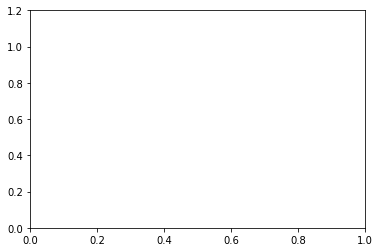

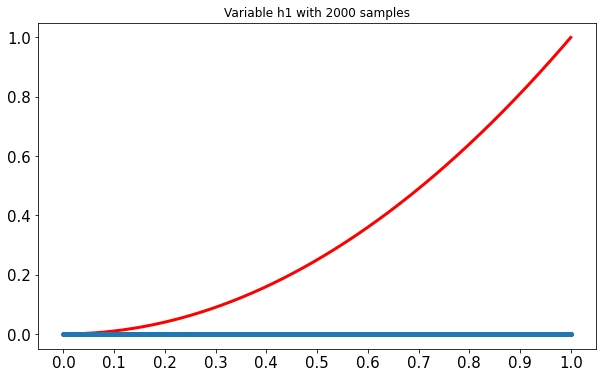

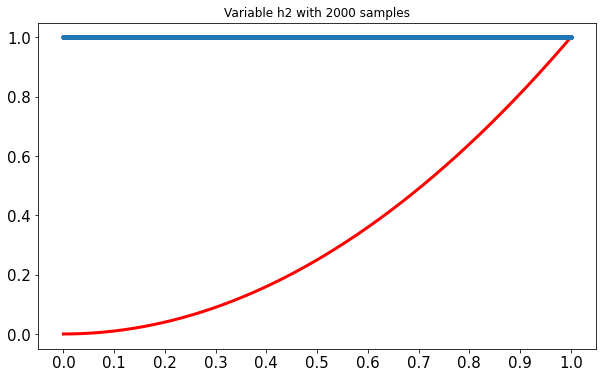

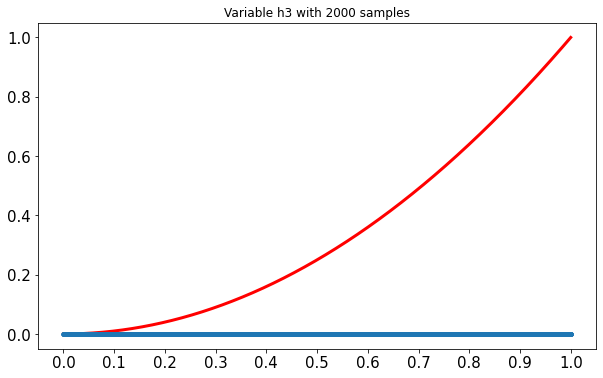

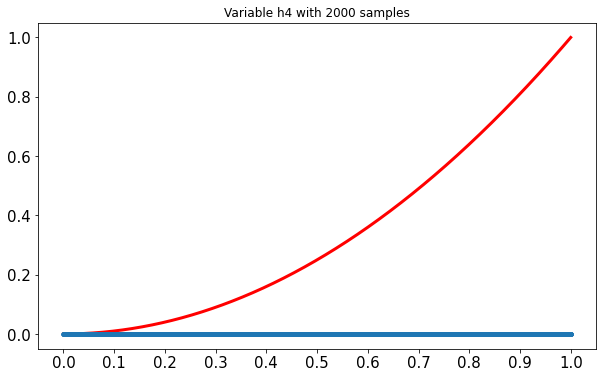

In [ ]:
# Single connected 4개 경우의 scatter plot.
import matplotlib.pyplot as plt
N = 10000 # plot N dots

x_grid = np.linspace(0, 1, N+1)
x_grid = x_grid[:-1]
y_grid = np.zeros(N)
ytrue = [amyfun(x_grid[i]) for i in range(N)]

y_predict = model1(x_valid.to(device))
y_predict = y_predict.cpu()
y_predict = y_predict.detach().numpy()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h1_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax = plt.gca()
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)  
plt.scatter(x_grid, y_grid,s=12,zorder=10)
  
plt.title('Variable h1 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h2_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5) 
plt.scatter(x_grid, y_grid,s=12,zorder=10)
   
plt.title('Variable h2 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h3_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red')   

plt.scatter(x_grid, y_grid,s=12,zorder=10)
 
plt.title('Variable h3 with '+str(len_data)+' samples',zorder=5)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

for i in range(N):
  a = np.random.rand(1,1)
  a[0][0] = i/N
  t = torch.from_numpy(a).float()
  y_grid[i] = model1.h4_tNet(t).detach().numpy()[0][0]

ymin = 0
ymax = 1.2
ax.set_ylim([ymin, ymax])

plt.figure(figsize=(10,6))
plt.plot(x_grid,ytrue,linewidth=3,color='red',zorder=5)    
plt.scatter(x_grid, y_grid,s=12,zorder=10)

plt.title('Variable h4 with '+str(len_data)+' samples')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()


